# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

## GPU Test

In [3]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
## Checking the GPU configuration
!nvidia-smi

Tue Nov  7 20:33:54 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.58                 Driver Version: 537.58       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
|100%   41C    P0              73W / 300W |   1367MiB / 11264MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Import dataset

In [5]:
# Unzipping
import zipfile
zip_path = 'Project_data.zip'
extract_path = 'Project_data'

In [6]:
if os.path.isdir(extract_path) == False or os.path.isdir(extract_path+'/Project_data/train') == False or os.path.isdir(extract_path+'/Project_data/val') == False:
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [7]:
train_doc = np.random.permutation(open(extract_path + '/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open(extract_path + '/Project_data/val.csv').readlines())
batch_size = 64 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
def cropResize(image, y, z):
    h, w = image.shape
    # if smaller image crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]
    # resize every image
    return resize(image, (y,z))

In [9]:
def normalizeImage(image):
    # applying normalization
    return image/255.0

In [10]:
def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))

In [11]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

In [12]:
def getGestureImages(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 120, 120, 3]

# define image tensor size
gesture_images = getGestureImages(30)
print ('# gesture_images =', gesture_images)

# gesture_images = [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 120, 120, 3]


In [13]:
def getBatchData(source_path, t, batch, batch_size, folder_size, gesture_images):
    img_idx = gesture_images[0] #create a list of image numbers you want to use for a particular video
    [x, y, z] = [len(img_idx), gesture_images[1], gesture_images[2]]
    batch_data = np.zeros((folder_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((folder_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(folder_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape
            #and the conv3D will throw error if the inputs in a batch have different shapes

            batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z) #normalise and feed in the image
            batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z) #normalise and feed in the image
            batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z) #normalise and feed in the image

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels


In [14]:
def generator(source_path, folder_list, batch_size, gesture_images):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    folder_size = batch_size
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            yield getBatchData(source_path, t, batch, batch_size, folder_size, gesture_images) #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        if len(t)%batch_size != 0:
            #updated the folder size and yied
            folder_size = len(t)%batch_size
            yield getBatchData(source_path, t, num_batches, batch_size, folder_size, gesture_images)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [15]:
curr_dt_time = datetime.datetime.now()
train_path = extract_path + '/Project_data/train'
val_path = extract_path + '/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


In [16]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, gesture_images)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, gesture_images)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  Project_data/Project_data/train ; batch size = 64
(64, 30, 120, 120, 3)
Source path =  Project_data/Project_data/val ; batch size = 64
(64, 30, 120, 120, 3)


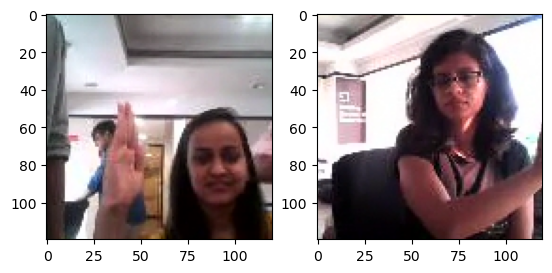

In [17]:
# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_val_batch_data[12,10,:,:,:])
ax[1].imshow(sample_val_batch_data[15,10,:,:,:])
plt.show()

In [18]:
# Plot model performance through epochs
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validation Accuracy", max(h.history['val_categorical_accuracy']))

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Model Conv3D

The first model we tried is Convolutional 3D with layers of Convolutional 3D, Max Pooling 3D, Batch Normalization. 

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Flatten, BatchNormalization, Dropout, Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
def model_3D_fit(n_frames, batch_size, num_epochs):
    gesture_images = getGestureImages(n_frames)
    #Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.
    train_generator = generator(train_path, train_doc, batch_size, gesture_images)
    val_generator = generator(val_path, val_doc, batch_size, gesture_images)

    #The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    curr_dt_time = datetime.datetime.now()

    model_name = 'model_3D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
    callbacks_list = [checkpoint, LR]

    inputShape = (len(gesture_images[0]), gesture_images[1], gesture_images[2], gesture_images[3])
            
    model = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])

    # Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.
    optimiser = optimizers.adam_v2.Adam() #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    #Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
    model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return model_history, model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 26, 116, 116, 16)  6016      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 13, 58, 58, 16)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 58, 58, 16)   64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 11, 56, 56, 32)    13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 11, 28, 28, 32)   0         
 3D)                                                             
                                                        

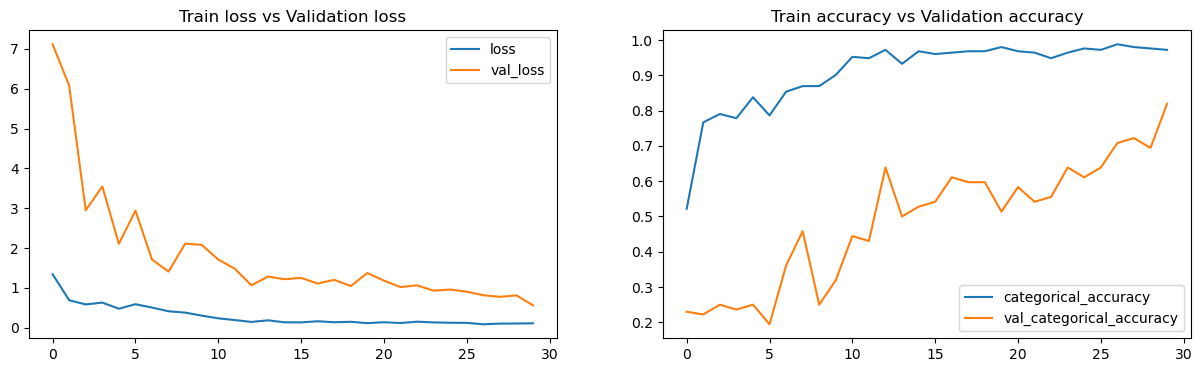

Max. Training Accuracy 0.9881423115730286
Max. Validation Accuracy 0.8194444179534912


In [20]:
# Fit model Conv3D and plot the model performance throughout epochs
model_3D_hist, model_3D_exp1 = model_3D_fit(n_frames=30, batch_size=64, num_epochs=30)
plotModelHistory(model_3D_hist)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 26, 116, 116, 16)  6016      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 13, 58, 58, 16)   0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 13, 58, 58, 16)   64        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 11, 56, 56, 32)    13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 11, 28, 28, 32)   0         
 3D)                                                             
                                                      

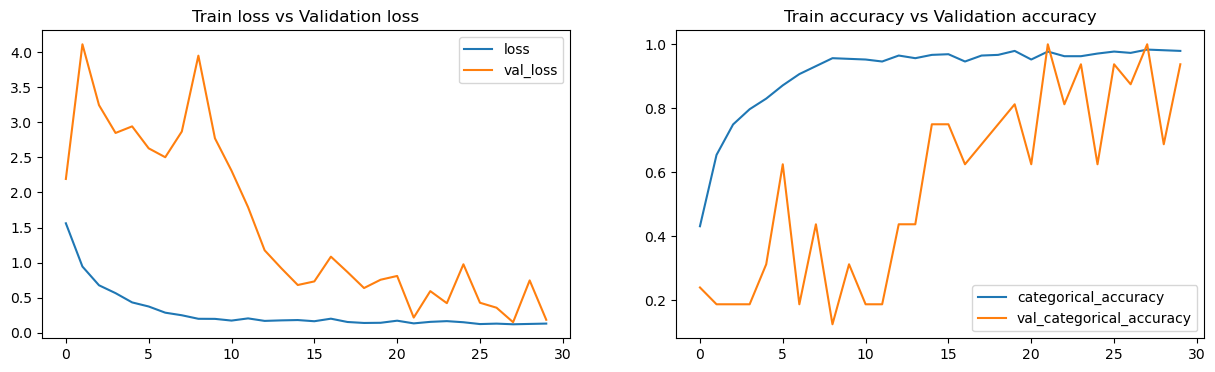

Max. Training Accuracy 0.9834368824958801
Max. Validation Accuracy 1.0


In [21]:
# Reduce batch size to 32 of model Conv3D
model_3D_hist, model_3D_exp2 = model_3D_fit(n_frames=30, batch_size=32, num_epochs=30)
plotModelHistory(model_3D_hist)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 26, 116, 116, 16)  6016      
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 13, 58, 58, 16)   0         
 3D)                                                             
                                                                 
 batch_normalization_10 (Bat  (None, 13, 58, 58, 16)   64        
 chNormalization)                                                
                                                                 
 conv3d_7 (Conv3D)           (None, 11, 56, 56, 32)    13856     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 11, 28, 28, 32)   0         
 3D)                                                             
                                                      

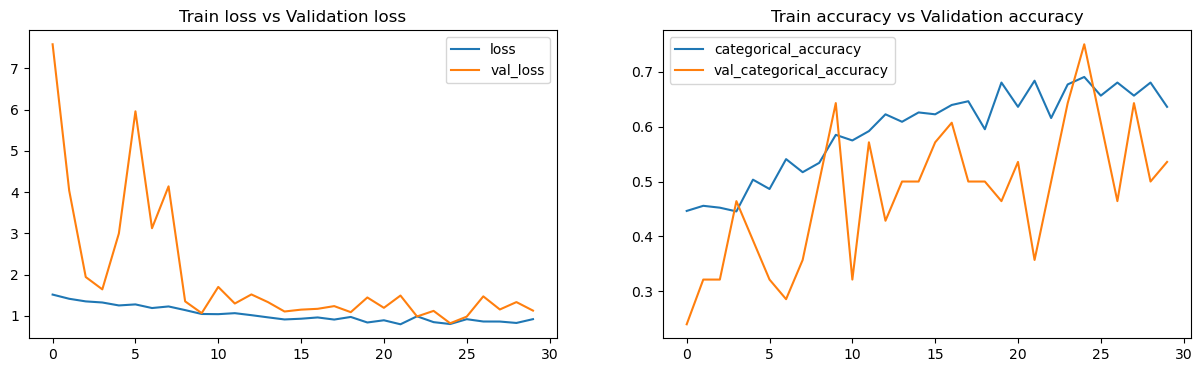

Max. Training Accuracy 0.6904761791229248
Max. Validation Accuracy 0.75


In [22]:
# Reduce batch size to 16 of model Conv3D 
model_3D_hist, model_3D_exp3 = model_3D_fit(n_frames=30, batch_size=16, num_epochs=30)
plotModelHistory(model_3D_hist)

### Model Conv2D & LSTM

The second model we tried is Convolutional 2D and LSTM.

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, TimeDistributed, Conv2D, MaxPooling2D, BatchNormalization, CuDNNLSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

def model_LSTM_fit(n_frames, batch_size, num_epochs):
    gesture_images = getGestureImages(n_frames)
    train_generator = generator(train_path, train_doc, batch_size, gesture_images)
    val_generator = generator(val_path, val_doc, batch_size, gesture_images)

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    curr_dt_time = datetime.datetime.now()

    model_name = 'model_2D_LSTM' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
    callbacks_list = [checkpoint, LR]

    inputShape = (len(gesture_images[0]), gesture_images[1], gesture_images[2], gesture_images[3])
            
    model = Sequential([
        TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Flatten()),
        CuDNNLSTM(256),
        Dropout(0.2),

        Dense(256, activation='relu'),
        Dropout(0.2),

        Dense(5, activation='softmax')
    ])

    optimiser = optimizers.adam_v2.Adam() #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())

    model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return model_history, model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 60, 60, 32)  

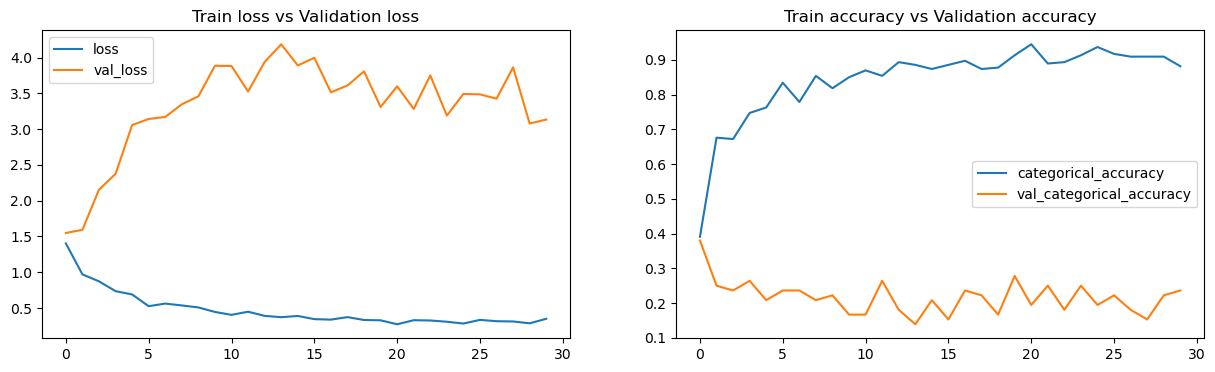

Max. Training Accuracy 0.9446640610694885
Max. Validation Accuracy 0.3799999952316284


In [24]:
# Fit the model Conv2D + LSTM
model_2D_lstm_hist, model_2D_lstm_exp1 = model_LSTM_fit(n_frames=20, batch_size=64, num_epochs=30)
plotModelHistory(model_2D_lstm_hist)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 30, 60, 60, 32)  

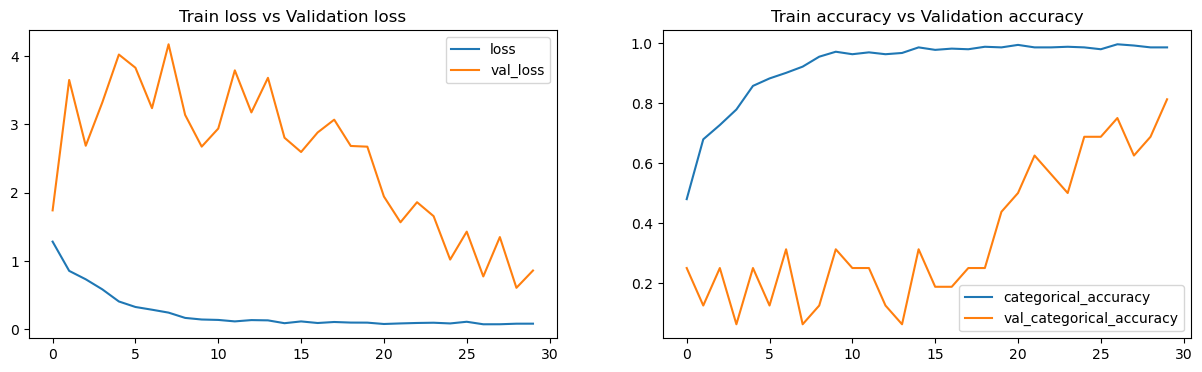

Max. Training Accuracy 0.9958592057228088
Max. Validation Accuracy 0.8125


In [25]:
# Reduce batch size to 32 of model Conv2D + LSTM
model_2D_lstm_hist, model_2D_lstm_exp2 = model_LSTM_fit(n_frames=30, batch_size=32, num_epochs=30)
plotModelHistory(model_2D_lstm_hist)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 30, 60, 60, 32)  

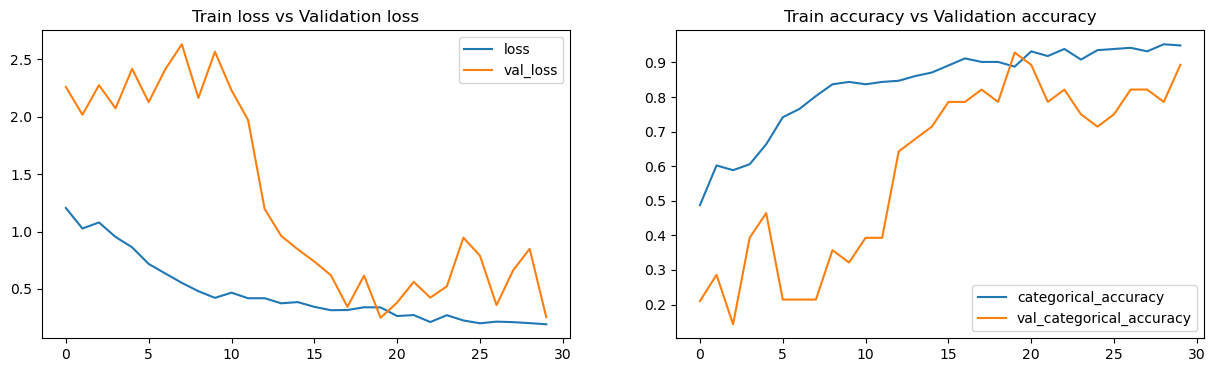

Max. Training Accuracy 0.9523809552192688
Max. Validation Accuracy 0.9285714030265808


In [26]:
# Reduce batch size to 16 of model Conv2D + LSTM
model_2D_lstm_hist, model_2D_lstm_exp3 = model_LSTM_fit(n_frames=30, batch_size=16, num_epochs=30)
plotModelHistory(model_2D_lstm_hist)

### Model Conv2D & Bi-LSTM

The third model that we tried is Conv2D and Bi-directional LSTM.

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, TimeDistributed, Conv2D, MaxPooling2D, BatchNormalization, Bidirectional, CuDNNLSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

def model_Bi_LSTM_fit(n_frames, batch_size, num_epochs):
    gesture_images = getGestureImages(n_frames)
    train_generator = generator(train_path, train_doc, batch_size, gesture_images)
    val_generator = generator(val_path, val_doc, batch_size, gesture_images)

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    curr_dt_time = datetime.datetime.now()

    model_name = 'model_2D_Bi_LSTM' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
    callbacks_list = [checkpoint, LR]

    inputShape = (len(gesture_images[0]), gesture_images[1], gesture_images[2], gesture_images[3])
            
    model = Sequential([
        TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Flatten()),
        Bidirectional(CuDNNLSTM(256)), # Optimized for NVIDIA GPU
        Dropout(0.2),

        Dense(256, activation='relu'),
        Dropout(0.2),

        Dense(5, activation='softmax')
    ])

    optimiser = optimizers.adam_v2.Adam() #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())

    model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return model_history, model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_48 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (None, 30, 60, 60, 32)  

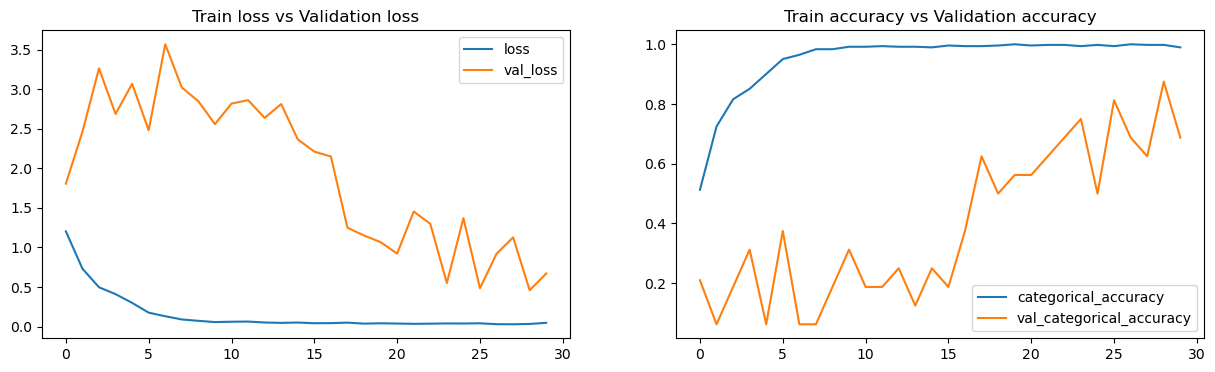

Max. Training Accuracy 1.0
Max. Validation Accuracy 0.875


In [28]:
# Fit the model Conv2D + Bi-LSTM 
model_2D_BiLSTM_hist, model_2D_BiLSTM_exp1 = model_Bi_LSTM_fit(n_frames=30, batch_size=32, num_epochs=30)
plotModelHistory(model_2D_BiLSTM_hist)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_64 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_68 (TimeDi  (None, 30, 60, 60, 32)  

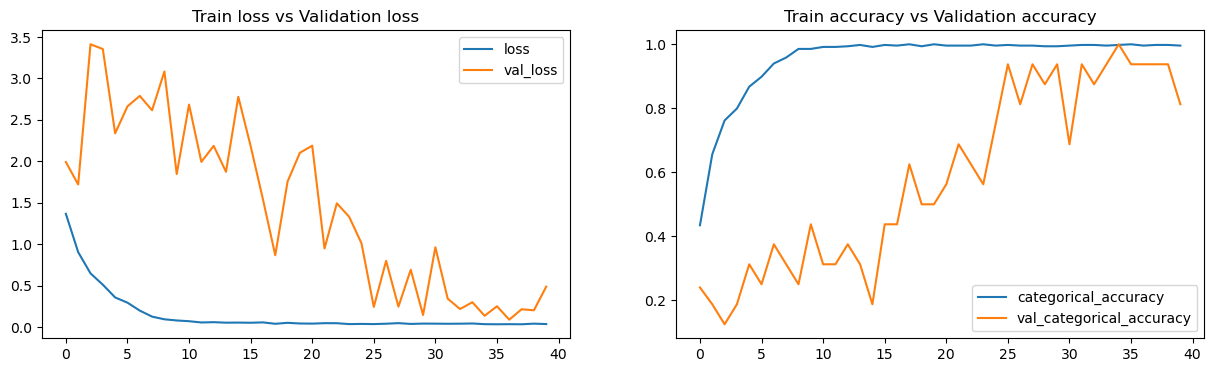

Max. Training Accuracy 1.0
Max. Validation Accuracy 1.0


In [29]:
# Increase number of epochs to 40 of model Conv2D + BiLSTM
model_2D_BiLSTM_hist, model_2D_BiLSTM_exp2 = model_Bi_LSTM_fit(n_frames=30, batch_size=32, num_epochs=40)
plotModelHistory(model_2D_BiLSTM_hist)

### Model Conv2D & GRU

The fourth model we tried is Convolutional 2D and GRU. (Optimized for NVIDIA GPU)

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, TimeDistributed, Conv2D, MaxPooling2D, BatchNormalization, CuDNNGRU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

def model_GRU_fit(n_frames, batch_size, num_epochs):
    gesture_images = getGestureImages(n_frames)
    train_generator = generator(train_path, train_doc, batch_size, gesture_images)
    val_generator = generator(val_path, val_doc, batch_size, gesture_images)

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    curr_dt_time = datetime.datetime.now()

    model_name = 'model_2D_GRU' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
    callbacks_list = [checkpoint, LR]

    inputShape = (len(gesture_images[0]), gesture_images[1], gesture_images[2], gesture_images[3])
            
    model = Sequential([
        TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Flatten()),
        CuDNNGRU(256), # Optimized for NVIDIA GPU
        Dropout(0.2),

        Dense(256, activation='relu'),
        Dropout(0.2),

        Dense(5, activation='softmax')
    ])

    optimiser = optimizers.adam_v2.Adam() #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())

    model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return model_history, model

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_80 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_81 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_82 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_83 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_84 (TimeDi  (None, 30, 60, 60, 32)  

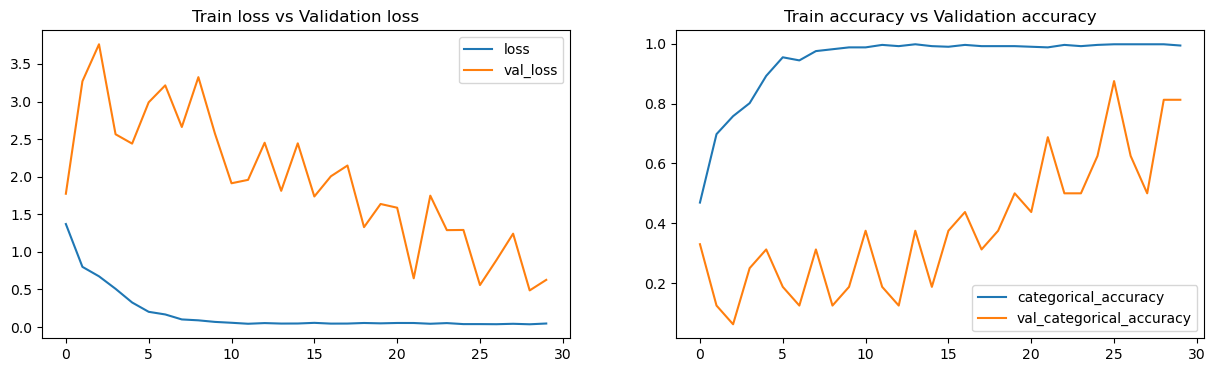

Max. Training Accuracy 0.9979296326637268
Max. Validation Accuracy 0.875


In [31]:
# Fit the model Conv2D + GRU
model_2D_GRU_hist, model_2D_GRU_exp1 = model_GRU_fit(n_frames=30, batch_size=32, num_epochs=30)
plotModelHistory(model_2D_GRU_hist)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_96 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_97 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_98 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_99 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_100 (TimeD  (None, 30, 60, 60, 32)  

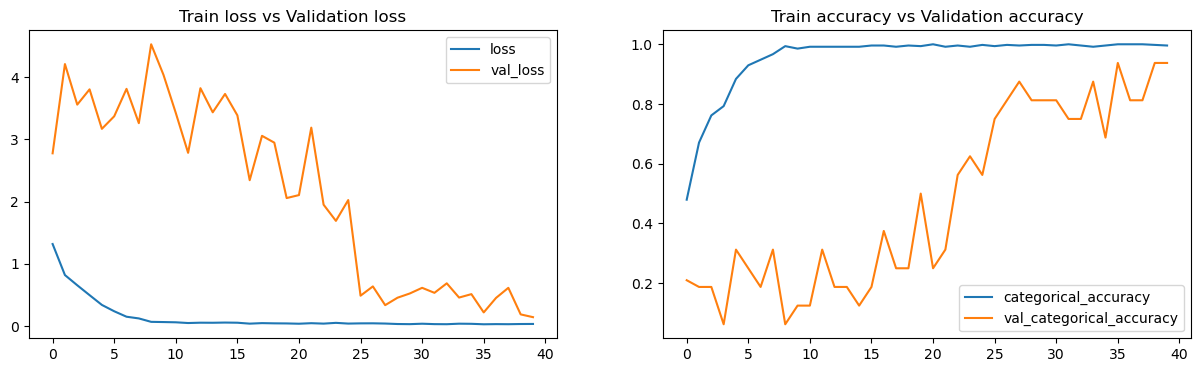

Max. Training Accuracy 1.0
Max. Validation Accuracy 0.9375


In [32]:
# Increase the epochs to 40 of model Conv2D + GRU
model_2D_GRU_hist, model_2D_GRU_exp2 = model_GRU_fit(n_frames=30, batch_size=32, num_epochs=40)
plotModelHistory(model_2D_GRU_hist)

### Transfer Learning (MobileNet) with LSTM

The fifth model we tried is Transfer learning from MobileNet and LSTM.

In [33]:
from keras.applications.mobilenet import MobileNet
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, TimeDistributed, Conv2D, MaxPooling2D, BatchNormalization, CuDNNLSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

def model_MobileNet_LSTM_fit(n_frames, batch_size, num_epochs):
    mobilenet = MobileNet(weights='imagenet', include_top=False)
    gesture_images = getGestureImages(n_frames)
    train_generator = generator(train_path, train_doc, batch_size, gesture_images)
    val_generator = generator(val_path, val_doc, batch_size, gesture_images)

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    curr_dt_time = datetime.datetime.now()

    model_name = 'model_2D_MobileNet_LSTM' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
    callbacks_list = [checkpoint, LR]

    inputShape = (len(gesture_images[0]), gesture_images[1], gesture_images[2], gesture_images[3])

    base_model = Sequential([
    TimeDistributed(mobilenet, input_shape=inputShape)])

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model, # Transfer learning from MobileNet
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),
        TimeDistributed(Flatten()),
        CuDNNLSTM(256),
        Dropout(0.2),

        Dense(256, activation='relu'),
        Dropout(0.2),

        Dense(5, activation='softmax')
    ])

    optimiser = optimizers.adam_v2.Adam() #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())

    model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return model_history, model

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_18 (Sequential)  (None, 30, 3, 3, 1024)    3228864   
                                                                 
 time_distributed_129 (TimeD  (None, 30, 3, 3, 1024)   4096      
 istributed)                                                     
                                                                 
 time_distributed_130 (TimeD  (None, 30, 1, 1, 1024)   0         
 istributed)                                                     
                                                                 
 time_distributed_131 (TimeD  (None, 30, 1024)         0         
 istributed)                                                     
                                                                 
 cu_dnnlstm_9 (CuDNNLSTM)    (None, 256)               1312768   
                                                     

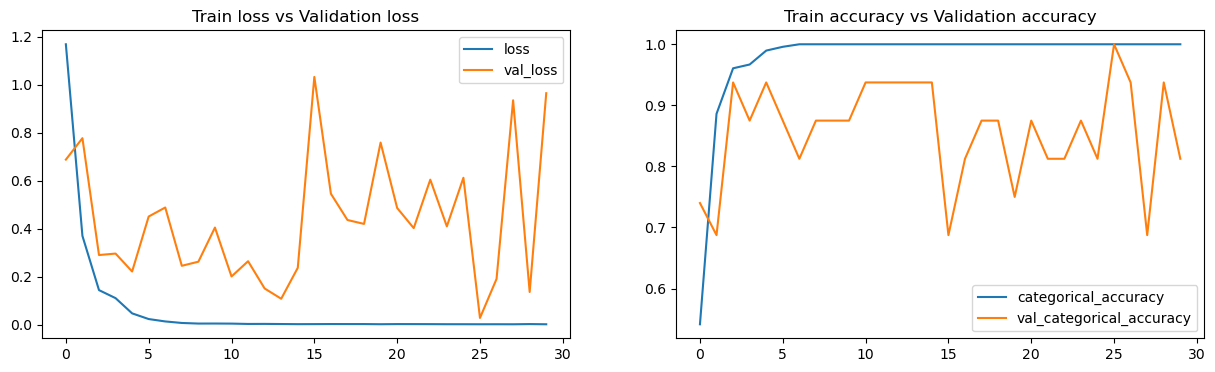

Max. Training Accuracy 1.0
Max. Validation Accuracy 1.0


In [38]:
# Fit model transfering-learning from MobileNet and LSTM
model_2D_MobileNet_LSTM_hist, model_2D_MobileNet_LSTM_exp1 = model_MobileNet_LSTM_fit(n_frames=30, batch_size=32, num_epochs=30)
plotModelHistory(model_2D_MobileNet_LSTM_hist)

# Final Model

The best model is Convolutional 2D + Bi-directional LSTM with batch size=32 and epoch number=40. 

In [39]:
# Export the model final h5 file
model_2D_BiLSTM_exp2.save('ThucAnh_ManhTruong_final_model_Conv2D_BiLSTM.h5')